In [1]:
# Import Dependencies
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("fish.csv")

In [9]:
# Label Encoding
coding = {k:v for k, v in zip(df[' c'].unique(), range(df['Species'].nunique()))}
df['Species'] = df.Species.replace(coding)

In [225]:
# Splitting the data
X = df.drop('Species', axis=1)
y = df['Species']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [227]:
X_train.head()

,Weight,Length1,Length2,Length3,Height,Width
89,135.0,20.0,22.0,23.5,5.8750,3.5250
100,197.0,23.5,25.6,27.0,6.5610,4.2390
9,500.0,28.5,30.7,36.2,14.2266,4.9594
43,150.0,20.4,22.0,24.7,5.8045,3.7544
62,60.0,14.3,15.5,17.4,6.5772,2.3142


In [228]:
# Standard Scaling the data
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

In [426]:
import itertools
import datetime
from sklearn.model_selection import GridSearchCV

class MLTuner:
    def __init__(self):
        pass
    
    def combinations_generator(self, searching_space):
        hyperparameters = sorted(searching_space)
        combinations = itertools.product(*(searching_space[hyperparameter] for hyperparameter in hyperparameters))
        for combination in combinations:
            yield {k:[v] for k, v in zip(hyperparameters, combination)}

    def get_space_size(self, searching_space):
        prodcut = 1
        for i in range(len(list(searching_space.values()))):
            prodcut *= len(list(searching_space.values())[i])

        return prodcut
    
    def fit(self, primary_estimator, secondary_estimator, X, y):
        self.primary_estimator = primary_estimator
        self.secondary_estimator = secondary_estimator
        self.X = X
        self.y = y
        self.searching_space = searching_space
    
    def search(self, searching_space, cv, min_sampling_size, min_checking_freq, secondary_scoring_threshold):
        hp_samples = pd.DataFrame(columns=list(searching_space.keys()))
        searching_space = {k:list(v) for k, v in searching_space.items()}
        
        searching_space_size = get_space_size(self.searching_space)
        
        secondary_score_track = []
        
        count = 1
        for p in self.combinations_generator(self.searching_space):
            estimator = GridSearchCV(self.primary_estimator, p, verbose=0)
            estimator.fit(self.X, self.y)
            sample = pd.DataFrame([v[0] for v in p.values()] + [estimator.best_score_], index=[k for k in p.keys()] + ["score"]).T
            hp_samples = hp_samples.append(sample)
            
            if len(hp_samples) >= min_sampling_size:
                if len(hp_samples) % min_checking_freq == 0:
                    X_sample = hp_samples.drop('score', axis=1)
                    y_sample = hp_samples['score']
                    secondary_score = cross_val_score(estimator=self.secondary_estimator, X=X_sample, y=y_sample, cv=cv, scoring="neg_mean_absolute_error").mean()
                    now = datetime.datetime.now()
                    current_time = now.strftime("%H:%M:%S")
                    print(f"{current_time}  {count}/{searching_space_size}  Secondary Score: {secondary_score}")
                    secondary_score_track.append(secondary_score)
                    
                    self.hp_samples.to_csv("hp_samples.csv", index=False)
                    
                    if secondary_score >= secondary_scoring_threshold:
                        print("Done Sampling.")
                        break
                
            count += 1
        
        self.secondary_score_track = secondary_score_track
        self.hp_samples = hp_samples

In [427]:
searching_space = {
    "learning_rate": [0.001, 0.01, 0.1], 
    "max_depth":np.arange(1, 16), 
    "n_estimators":[int(i) for i in np.arange(1, 1000, 10)]
}

In [430]:
xgbc = XGBClassifier(use_label_encoder=False, verbosity=0)
xgbr = XGBRegressor()
mlt = MLTuner()
mlt.fit(xgbc, xgbr, X_train_std, y_train)
mlt.search(searching_space, 2, 1, 100, -0.0001)

09:42:42	100/4500	Secondary Score: -0.006451248946397224
10:00:28	200/4500	Secondary Score: -0.04648479269812071
10:24:42	300/4500	Secondary Score: -0.03760059125642271
10:53:13	400/4500	Secondary Score: -0.04308208072876586
11:23:59	500/4500	Secondary Score: -0.03358460127201634
11:57:01	600/4500	Secondary Score: -0.03279915167225733
12:29:43	700/4500	Secondary Score: -0.034788598738348525
13:01:49	800/4500	Secondary Score: -0.032262172547803426
13:36:38	900/4500	Secondary Score: -0.02753811174256791
14:09:22	1000/4500	Secondary Score: -0.01854838040013245
14:41:04	1100/4500	Secondary Score: -0.015874612087945862
15:14:44	1200/4500	Secondary Score: -0.0147426383668098
15:47:21	1300/4500	Secondary Score: -0.014009159783987441
16:19:45	1400/4500	Secondary Score: -0.015698548902018966
16:52:34	1500/4500	Secondary Score: -0.014491910281043121
17:04:06	1600/4500	Secondary Score: -0.013460804975335148
17:21:57	1700/4500	Secondary Score: -0.01276385490648379
17:46:07	1800/4500	Secondary Scor

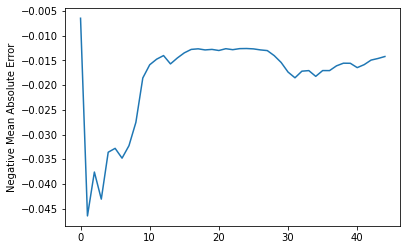

In [455]:
# Inspect the training process
plt.plot(mlt.secondary_score_track)
plt.ylabel("Negative Mean Absolute Error")
plt.show()

In [432]:
# Save Our Result
hp_samples = mlt.hp_samples
hp_samples.to_csv("hp_samples.csv", index=False)

In [435]:
X2 = hp_samples.drop("score", axis=1)
y2 = hp_samples["score"]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, shuffle=True)

In [456]:
xgbr = XGBRegressor()
mean_neg_mae = cross_val_score(X=X_train2, y=y_train2, estimator=xgbr, cv=5, scoring="neg_mean_absolute_error").mean()
print(mean_neg_mae)

-0.0027313016229077707


In [457]:
xgbr.fit(X_train2, y_train2)
y_pred2 = xgbr.predict(X_test2)
print(sum(abs(y_pred2 - y_test2))/len(y_test2))

0.0026559311997295305


In [450]:
hp_samples.sort_values("score", ascending=False)

,learning_rate,max_depth,n_estimators,score
0,0.001,4.0,931.0,0.739493
0,0.001,4.0,891.0,0.739493
0,0.001,4.0,861.0,0.739493
0,0.001,4.0,921.0,0.739493
0,0.001,4.0,841.0,0.739493
...,...,...,...,...
0,0.010,1.0,331.0,0.604348
0,0.010,1.0,351.0,0.604348
0,0.100,1.0,31.0,0.587319
0,0.010,1.0,311.0,0.587319


In [473]:
hp_samples[hp_samples.score >= 0.739]

,learning_rate,max_depth,n_estimators,score
0,0.001,4.0,831.0,0.739493
0,0.001,4.0,841.0,0.739493
0,0.001,4.0,851.0,0.739493
0,0.001,4.0,861.0,0.739493
0,0.001,4.0,871.0,0.739493
0,0.001,4.0,881.0,0.739493
0,0.001,4.0,891.0,0.739493
0,0.001,4.0,901.0,0.739493
0,0.001,4.0,911.0,0.739493
0,0.001,4.0,921.0,0.739493


In [458]:
%%time
xgbr.predict(pd.DataFrame([0.0001, 4, 931], index=['learning_rate', 'max_depth', 'n_estimators']).T)

CPU times: user 3.49 ms, sys: 1.36 ms, total: 4.85 ms
Wall time: 2.89 ms


array([0.73519367], dtype=float32)

In [459]:
%%time
cross_val_score(xgbc, X_train_std, y_train, cv=5).mean()

CPU times: user 5.38 s, sys: 4.4 s, total: 9.78 s
Wall time: 2.01 s


0.6884057971014493

In [461]:
factor_k = 2.01/(2.89e-3)
print(f"The time spent ratio between gridcv search and MLT prediction for one point: {factor_k}")

The time spent ratio between gridcv search and MLT prediction for one point: 695.5017301038062


In [482]:
res = pd.DataFrame(columns=['learning_rate', 'max_depth', 'n_estimators', 'score'])
for ne in np.arange(831, 1001):
    score = xgbr.predict(pd.DataFrame([0.0001, 4, ne], index=['learning_rate', 'max_depth', 'n_estimators']).T)
    res = res.append(pd.DataFrame([0.0001, 4, ne] + [score[0]], index=['learning_rate', 'max_depth', 'n_estimators', 'score']).T)

In [483]:
res.sort_values("score", ascending=False)

,learning_rate,max_depth,n_estimators,score
0,0.0001,4.0,927.0,0.735194
0,0.0001,4.0,935.0,0.735194
0,0.0001,4.0,934.0,0.735194
0,0.0001,4.0,933.0,0.735194
0,0.0001,4.0,932.0,0.735194
...,...,...,...,...
0,0.0001,4.0,980.0,0.730210
0,0.0001,4.0,985.0,0.730210
0,0.0001,4.0,984.0,0.730210
0,0.0001,4.0,983.0,0.730210


In [486]:
xgbc = XGBClassifier(use_label_encoder=False, learning_rate=0.0001, max_depth=4, n_estimators=927)
cross_val_score(xgbc, X_train_std, y_train, cv=5).mean()

0.7061594202898551

# Conclusion

Although the idea of using another ML model to model the predict the optimum hyparameters could be theoretically more time saving, its effectiveness seems being hindered by the accuracy of secondary ML model. Different datasets (real world data, various sizes...) should be investigated with other ML models as well.